In [1]:
# Instalar autokerassss
#!pip install autokeras

In [2]:
#!pip install wordcloud
#!pip install cufflinks

In [3]:
# Configurar interface do Jupyter Notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>pre { font-size: 12px !important; }</style>"))

### Importar bibliotecas

In [4]:
import autokeras as ak
import cufflinks as cf
import json
import keras
import numpy as np
import matplotlib.pyplot as plt
import nltk
import pandas as pd 
import pydot
import seaborn as sns
import sklearn.metrics as skm
import tensorflow as tf

from clearml               import Task
from datetime              import datetime
from PIL                   import Image
from sklearn               import model_selection
from sklearn.metrics       import confusion_matrix
from sklearn.metrics       import multilabel_confusion_matrix
from keras.utils.vis_utils import plot_model
from tensorflow            import keras
from wordcloud             import WordCloud

/home/t0085217/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


### Conectar ClearML ao processo atual do notebook

In [5]:
task = Task.init(project_name="autokeras", task_name="TCC - AutoKeras - Final 1 Com Assuntos")

ClearML Task: created new task id=becd963a3189431ba0c3f0b200a80f11
ClearML results page: http://localhost:8080/projects/49ff0b771afd4c3591ce81a50c3fcb45/experiments/becd963a3189431ba0c3f0b200a80f11/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
2022-02-17 12:45:53,568 - clearml.storage - ERROR - Exception encountered while uploading Failed uploading object localhost:8081/autokeras/TCC - AutoKeras - Final 1 Com Assuntos.becd963a3189431ba0c3f0b200a80f11/metrics/Matriz de Confusão Normalizada - Classe/plot image/Matriz de Confusão Normalizada - Classe_plot image_00000000.png (500): <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<title>500 Internal Server Error</title>
<h1>Internal Server Error</h1>
<p>The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.</p>

2022-02-17 12:45:53,572 - clearml.metrics - WARNING - Failed uploading

## Processamento/Tratamento de Dados

### Carregar dados de arquivo JSON gerado previamente fora do Notebook em um DataFrame Pandas

In [6]:
with open('dados-prd.json','r') as f:
    dados = json.loads(f.read())
df = pd.json_normalize(dados, record_path = ['processos'])
df.shape

ClearML new version available: upgrade to v1.1.6 is recommended!
======> WARNING! Git diff to large to store (2704kb), skipping uncommitted changes <======


(13428, 19)

### Identificar se há registros duplicados

In [7]:
dupes_id = df.pivot_table(columns=['id'], aggfunc='size')
dupes_id = pd.Series(dupes_id).where(lambda x : x > 1).dropna()
print(dupes_id)
print(dupes_id.size)

Series([], dtype: float64)
0


### Verificar cardinalidade dos atributos

In [8]:
df.drop('assuntos', axis=1).apply(pd.Series.nunique).sort_values(ascending=False)

hash                           13428
id                             13428
numero_antigo                  13428
documento                      13146
numero_partes_polo_ativo          32
numero_partes_polo_passivo        21
competencia_descricao             14
competencia_id                    14
classe_id                         13
classe_descricao                  13
assistencia_judiciaria             2
urgente_efeito_suspensivo          2
tipo_documento_id                  2
envolve_municipio                  2
envolve_ministerio_publico         2
envolve_estado_minas_gerais        2
cod_tipo_protocolo                 2
urgente_tutela_provisoria          2
dtype: int64

### Remover atributos não úteis com cardinalidade alta (todos são identificadores únicos dos registros)

In [9]:
df.drop(['hash', 'id', 'numero_antigo'], axis = 1, inplace = True)

### Remover atributos não úteis por serem redundantes no dataset

In [10]:
df.drop(['classe_descricao', 'competencia_descricao'], axis = 1, inplace = True)

### Verificar valores nulos no DataFrame

In [11]:
df.isnull().sum(axis = 0).where(lambda x : x > 0).dropna()

assuntos    3870.0
dtype: float64

### Verificar distribuição dos atributos alvo

In [12]:
plt.rcParams["figure.figsize"] = [12, 6]

Text(0.5, 1.0, 'classe_id')

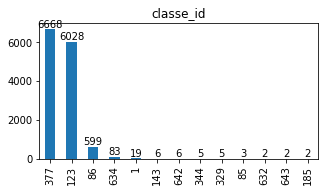

In [13]:
%matplotlib inline
lista_e_qtde = df['classe_id'].value_counts().sort_values(ascending=False)
ax = lista_e_qtde.plot.bar(figsize=(5,2.5))
ax.bar_label(ax.containers[0])
ax.set_title('classe_id')

Text(0.5, 1.0, 'competencia_id')

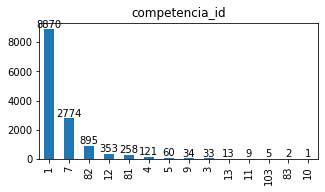

In [14]:
%matplotlib inline
lista_e_qtde = df['competencia_id'].value_counts().sort_values(ascending=False)
ax = lista_e_qtde.plot.bar(figsize=(5,2.5))
ax.bar_label(ax.containers[0])
ax.set_title('competencia_id')

In [15]:
# Open issue regarding inability to weight classes for multi-output models
# to deal with class inbalance issues
# https://github.com/tensorflow/tensorflow/issues/41448

# Remove registros cujas classes alvo possuem frequência muito baixa (< 100 registros)
df = df[df.groupby('classe_id')['classe_id'].transform('count').ge(100)]
df = df[df.groupby('competencia_id')['competencia_id'].transform('count').ge(100)]
print(df.shape)

(13141, 14)


[Text(0, 0, '6605'), Text(0, 0, '5946'), Text(0, 0, '590')]

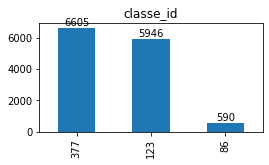

In [16]:
%matplotlib inline
lista_e_qtde = df['classe_id'].value_counts().sort_values(ascending=False)
#labels_classe = lista_e_qtde.index.to_list()
ax = lista_e_qtde.plot.bar(figsize=(4,2), title='classe_id')
ax.bar_label(ax.containers[0])

[Text(0, 0, '8817'),
 Text(0, 0, '2716'),
 Text(0, 0, '895'),
 Text(0, 0, '334'),
 Text(0, 0, '258'),
 Text(0, 0, '121')]

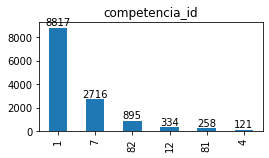

In [17]:
%matplotlib inline
lista_e_qtde = df['competencia_id'].value_counts().sort_values(ascending=False)
#labels_competencia = lista_e_qtde.index.to_list()
ax = lista_e_qtde.plot.bar(figsize=(4,2), title='competencia_id')
ax.bar_label(ax.containers[0])

#### Converter atributo "assuntos" que originalmente é uma Lista de listas de dicionários em uma matriz (lista de listas de IDs dos assuntos de cada processo)

In [18]:
print(df['assuntos'][0:3])
df['assuntos'] = df['assuntos'].apply(\
   lambda row: np.asarray( [assunto["id"] for assunto in row]\
                         ) if (np.all(pd.notnull(row))) else [])
print(df['assuntos'][0:3])

0    [{'descricao': 'Inadimplemento', 'id': 7691}, ...
1               [{'descricao': 'Liminar', 'id': 9196}]
2                                                 None
Name: assuntos, dtype: object
0    [7691, 8843]
1          [9196]
2              []
Name: assuntos, dtype: object


#### Verificar distribuição dos assuntos

[Text(0, 0, '3699'),
 Text(0, 0, '936'),
 Text(0, 0, '666'),
 Text(0, 0, '651'),
 Text(0, 0, '636'),
 Text(0, 0, '632'),
 Text(0, 0, '592'),
 Text(0, 0, '576'),
 Text(0, 0, '521'),
 Text(0, 0, '492'),
 Text(0, 0, '451'),
 Text(0, 0, '447'),
 Text(0, 0, '437'),
 Text(0, 0, '419'),
 Text(0, 0, '417'),
 Text(0, 0, '398'),
 Text(0, 0, '303'),
 Text(0, 0, '303'),
 Text(0, 0, '301'),
 Text(0, 0, '298'),
 Text(0, 0, '281'),
 Text(0, 0, '249'),
 Text(0, 0, '249'),
 Text(0, 0, '245'),
 Text(0, 0, '234'),
 Text(0, 0, '228'),
 Text(0, 0, '225'),
 Text(0, 0, '215'),
 Text(0, 0, '215'),
 Text(0, 0, '210'),
 Text(0, 0, '204'),
 Text(0, 0, '203'),
 Text(0, 0, '174'),
 Text(0, 0, '168'),
 Text(0, 0, '156'),
 Text(0, 0, '145'),
 Text(0, 0, '141'),
 Text(0, 0, '141'),
 Text(0, 0, '141'),
 Text(0, 0, '139'),
 Text(0, 0, '137'),
 Text(0, 0, '133'),
 Text(0, 0, '125'),
 Text(0, 0, '118'),
 Text(0, 0, '114'),
 Text(0, 0, '113'),
 Text(0, 0, '107'),
 Text(0, 0, '101'),
 Text(0, 0, '101'),
 Text(0, 0, '91'),


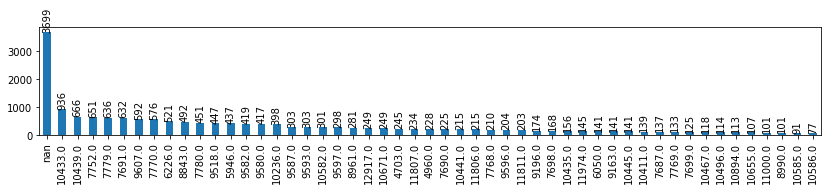

In [19]:
#lista_e_qtde = df['competencia_id'].value_counts().sort_values(ascending=False)
#labels_competencia = lista_e_qtde.index.to_list()
#ax = lista_e_qtde.plot.bar(figsize=(4,4), title='competencia_id')
#ax.bar_label(ax.containers[0])

#ax = df['assuntos'].explode().astype('Int32').value_counts(dropna=False).plot(  kind='bar'\
ax = df['assuntos'].explode().value_counts(dropna=False).plot(  kind='bar'\
                                                                         , figsize=(14,2))
ax.bar_label(ax.containers[0], rotation='vertical')

#### Transformar atributo assuntos aplicando técnica de One-Hot Encoding gerando uma coluna boleana para cada assunto do DataFrame

In [20]:
s = df['assuntos'].explode()
df_assuntos = pd.crosstab(s.index, s).add_prefix('ass_')
df = df.drop('assuntos', axis=1).join(df_assuntos)
# Preenche os novos atributos com zeros para os registros que não possuíam nenhum assunto.
df[df_assuntos.columns] = df[df_assuntos.columns].fillna(0)

### Exibir resumo do DataFrame

In [21]:
print(df.shape)
df.drop('documento', axis=1).head()

(13141, 63)


,assistencia_judiciaria,classe_id,cod_tipo_protocolo,competencia_id,envolve_estado_minas_gerais,envolve_ministerio_publico,envolve_municipio,numero_partes_polo_ativo,numero_partes_polo_passivo,tipo_documento_id,...,ass_10586,ass_10655,ass_10671,ass_10894,ass_11000,ass_11806,ass_11807,ass_11811,ass_11974,ass_12917
0,0,123,1,1,0,0,0,1,1,362,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,123,1,1,0,0,0,1,0,362,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,377,11,1,1,0,0,1,1,263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,86,1,1,1,0,0,1,1,362,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,377,11,7,1,0,0,1,3,263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Exploração dos dados

#### Avaliar correlação dos atributos

##### Atributos numéricos exceto os derivados de assunto

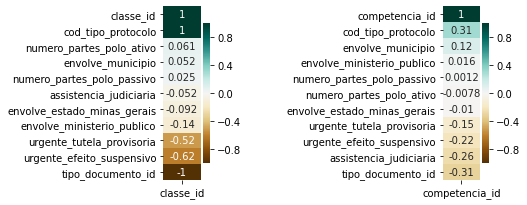

In [22]:
plt.rcParams['figure.figsize'] = [5.3, 3]
fig, axes = plt.subplots(1, 2)
fig.tight_layout()
plt.subplots_adjust(wspace=5)
sns.heatmap(df.drop(df_assuntos.columns, axis=1).drop('competencia_id', axis=1).corr(method ='pearson')[['classe_id']]\
            .sort_values(by='classe_id', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=axes[0])
sns.heatmap(df.drop(df_assuntos.columns, axis=1).drop('classe_id', axis=1).corr(method ='pearson')[['competencia_id']]\
            .sort_values(by='competencia_id', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=axes[1])
plt.show()

##### Atributos derivados de assunto

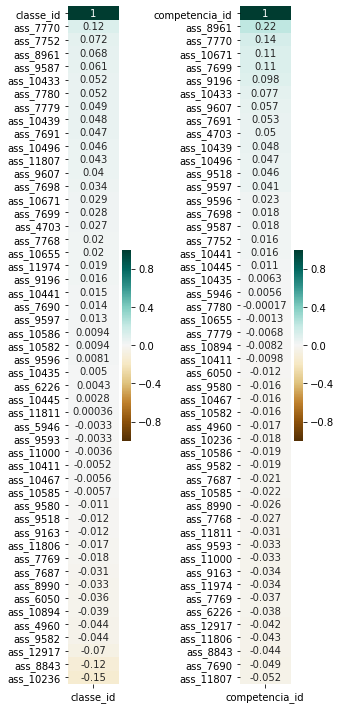

In [23]:
plt.rcParams['figure.figsize'] = [4, 10]
fig, axes = plt.subplots(1, 2)
fig.tight_layout()
plt.subplots_adjust(wspace=1.7)
sns.heatmap(df[df_assuntos.columns.tolist() + ['classe_id']].corr(method ='pearson')[['classe_id']].sort_values(by='classe_id', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=axes[0])
sns.heatmap(df[df_assuntos.columns.tolist() + ['competencia_id']].corr(method ='pearson')[['competencia_id']].sort_values(by='competencia_id', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=axes[1])
plt.show()

#### Dados textuais dos documentos processuais

In [24]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/t0085217/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

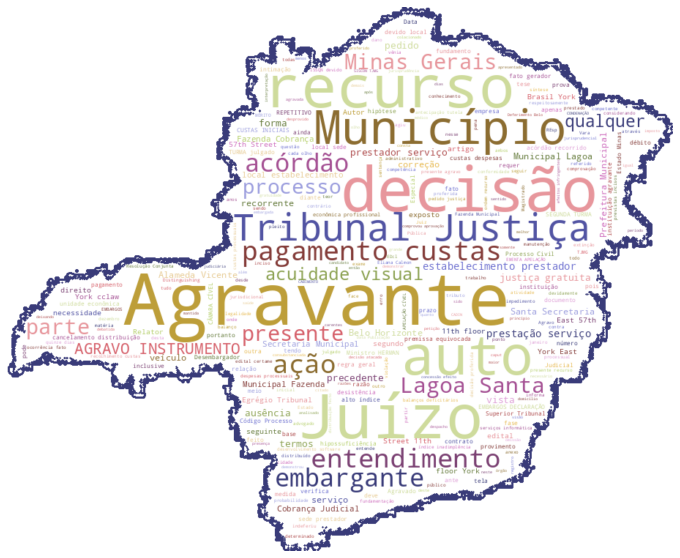

In [25]:
mask = np.array(Image.open('mapa-minas-gerais.jpg'))

stopwords = nltk.corpus.stopwords.words('portuguese') + ['pinzon','paulo','caso','assim','conforme','benjamin','sobre']
texto_documentos = df['documento'].values 
wordcloud = WordCloud( stopwords = stopwords, 
                       mask=mask,  
                       background_color = 'white',
                        width = 1000,
                        height = 400,
                        min_font_size = 4,
                        min_word_length = 4,
                        max_words = 300,
                        colormap='tab20b',
                        collocation_threshold = 30,
                        contour_color='#393b79',
                        contour_width=3).generate(str(texto_documentos))

plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [26]:
# Necessário para utilizar função iplot no objeto Series
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [27]:
# Calcular tamanho e qtde de palavras de cada documento do dataset
df_length     = df['documento'].astype(str).apply(len)
df_word_count = df['documento'].apply(lambda x: len(str(x).split()))

In [28]:
layout1 = cf.Layout(
    height=400,
    width=400,
    xaxis=dict(title="Tamanho do texto do documento"),
    yaxis=dict(title="Qtde de Registros") 
)
df_length.iplot(
    kind='hist',
    bins=50,
    linecolor='black',
    layout=layout1)

In [29]:
layout1 = cf.Layout(
    height=400,
    width=400,
    xaxis=dict(title="Qtde de palavras no documento"),
    yaxis=dict(title="Qtde de Registros") 
)
df_word_count.iplot(
    kind='hist',
    bins=60,
    linecolor='black',
    layout=layout1)

#### Dados estruturados

#### Distribuição dos atributos alvo

In [30]:
# Já realizada previamente quando da exclusão de registros cuja classe tinha baixa frequência

#### Atributos boleanos

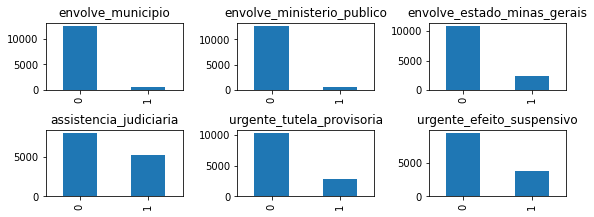

In [31]:
plt.rcParams['figure.figsize'] = [8, 3]
fig, axes = plt.subplots(2, 3)#, figsize=(10, 3)
fig.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.6)

axes[0,0].set_title('envolve_municipio')
axes[0,1].set_title('envolve_ministerio_publico')
axes[0,2].set_title('envolve_estado_minas_gerais')
axes[1,0].set_title('assistencia_judiciaria')
axes[1,1].set_title('urgente_tutela_provisoria')
axes[1,2].set_title('urgente_efeito_suspensivo')

df['envolve_municipio'].value_counts().plot(kind='bar', ax=axes[0,0])
df['envolve_ministerio_publico'].value_counts().plot(kind='bar', ax=axes[0,1])
df['envolve_estado_minas_gerais'].value_counts().plot(kind='bar', ax=axes[0,2])
df['assistencia_judiciaria'].value_counts().plot(kind='bar', ax=axes[1,0])
df['urgente_tutela_provisoria'].value_counts().plot(kind='bar', ax=axes[1,1])
df['urgente_efeito_suspensivo'].value_counts().plot(kind='bar', ax=axes[1,2])

plt.show()

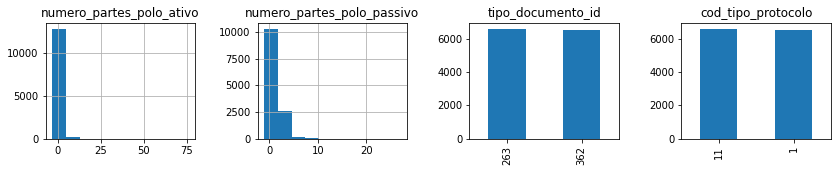

In [32]:
fig, axes = plt.subplots(1, 4)
fig.tight_layout()
fig.set_figheight(2)
fig.set_figwidth(12)
axes[0].set_title('numero_partes_polo_ativo')
axes[1].set_title('numero_partes_polo_passivo')
axes[2].set_title('tipo_documento_id')
axes[3].set_title('cod_tipo_protocolo')
df['numero_partes_polo_ativo'].hist(ax=axes[0])
df['numero_partes_polo_passivo'].hist(ax=axes[1])
df['tipo_documento_id'].value_counts().plot(kind='bar', ax=axes[2])
df['cod_tipo_protocolo'].value_counts().plot(kind='bar', ax=axes[3])
plt.show()

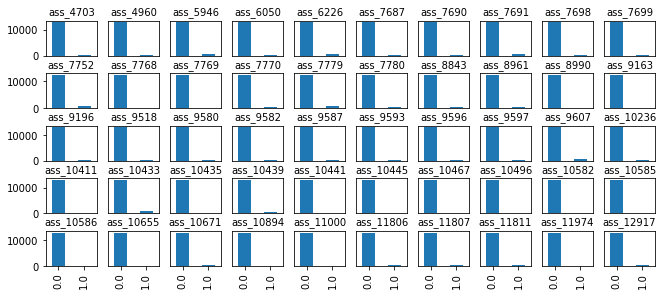

In [33]:
plt.rcParams['figure.figsize'] = [9, 4]
fig, axes = plt.subplots(5, 10)
fig.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.5)

m_colunas_assunto = np.array_split(df_assuntos.columns.tolist(), 5)
for i, row in enumerate(m_colunas_assunto):
    for j, col in enumerate(row):
        axes[i,j].set_title(col, fontsize = 10)
        df[col].value_counts().plot(kind='bar', ax=axes[i,j])
        if j > 0:
            axes[i,j].yaxis.set_visible(False)
        if i < 4:
            axes[i,j].xaxis.set_visible(False)

plt.show()

### Preparação da execução do Autokeras

#### Particionar os dados em DataFrames de treinamento e teste

In [34]:
df_train, df_test = model_selection.train_test_split(df, test_size=0.3, random_state=154)

#### Criar os dataframes específicos das entradas e saídas para serem pasados para o modelo

In [35]:
atrib_predit_nativos = ['cod_tipo_protocolo', 'numero_partes_polo_ativo', 'numero_partes_polo_passivo', 'tipo_documento_id',\
                        'assistencia_judiciaria', 'envolve_ministerio_publico', 'envolve_municipio', 'envolve_estado_minas_gerais',\
                        'urgente_efeito_suspensivo', 'urgente_tutela_provisoria']
atrib_predit_assuntos = df_assuntos.columns.tolist()
atrib_predit_estruturados = atrib_predit_nativos + atrib_predit_assuntos

df_train_text            = df_train['documento']
df_train_struct          = df_train[atrib_predit_estruturados]
df_train_labels_classe   = df_train['classe_id']
df_train_labels_comp     = df_train['competencia_id']
df_train_labels_assuntos = df_train[df_assuntos.columns]
df_test_text             = df_test['documento']
df_test_struct           = df_test[atrib_predit_estruturados]
df_test_labels_classe    = df_test['classe_id']
df_test_labels_comp      = df_test['competencia_id']
df_test_labels_assuntos  = df_test[df_assuntos.columns]

#### Tentativa (frustrada) de passar pesos para as classes das 3 tarefas de classificação

In [36]:
#from sklearn.utils import class_weight
#def generate_class_weights(sample_class_list):
#    unique  = np.unique(sample_class_list)
#    weights = class_weight.compute_class_weight( class_weight='balanced'
#                                               , classes=unique
#                                               , y=sample_class_list
#                                               )
#    return dict(zip(unique, weights))

In [37]:
# Gerar dicionários com lista de classes e seus respectivos pesos dado que o dataset não é balanceado
#from sklearn.utils import class_weight
#df_train_labels_classe_class_weight = generate_class_weights(df_train_labels_classe)
#df_train_labels_classe_comp_weight  = generate_class_weights(df_train_labels_comp)

#df_train_labels_classe_weight = {**df_train_labels_classe_class_weight, **df_train_labels_classe_comp_weight}

#### Criar o modelo

In [38]:
model = ak.AutoModel( 
      inputs     = [ ak.TextInput(), ak.StructuredDataInput() ]
    , outputs    = [ ak.ClassificationHead(loss='categorical_crossentropy', metrics=['accuracy'])
                   , ak.ClassificationHead(loss='categorical_crossentropy', metrics=['accuracy'])
                   , ak.ClassificationHead(loss='categorical_crossentropy', metrics=['accuracy'], multi_label=True)
                   ]
    , overwrite  = True
    , max_trials = 10
)

#### Criar callback e inicializar o TensorBoard

In [39]:
!rm -rf log
!rm -rf log/scalars
logdir = "log/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_train = keras.callbacks.TensorBoard(log_dir=logdir)

In [40]:
#!kill 109928
#limpar:  cd /tmp/.tensorboard-info

In [41]:
#temp
#'log/scalars/20220131-072550'
#%reload_ext tensorboard
#%tensorboard --logdir log/scalars

In [42]:
%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard --logdir log/scalars

Reusing TensorBoard on port 6006 (pid 7925), started 5 days, 13:29:06 ago. (Use '!kill 7925' to kill it.)

#### Treinar o modelo

In [43]:
model.fit( [df_train_text.to_numpy(), df_train_struct]
         , [df_train_labels_classe  , df_train_labels_comp, df_train_labels_assuntos] 
         , verbose=1
         , epochs=1000
         , callbacks=[ tensorboard_callback_train
         #            , tf.keras.callbacks.EarlyStopping(min_delta=0.0002, patience=10)
                     ]
         )


Trial 10 Complete [00h 05m 17s]
val_loss: 0.723611056804657

Best val_loss So Far: 0.6504853963851929
Total elapsed time: 00h 46m 40s
INFO:tensorflow:Oracle triggered exit
2022-02-17 09:07:52,913 - clearml - WARNING - ('Could not serialize configuration dictionary:\n', {'class_name': 'Functional', 'config': {'name': 'model', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None,), 'dtype': 'string', 'sparse': False, 'ragged': False, 'name': 'input_1'}, 'name': 'input_1', 'inbound_nodes': []}, {'class_name': 'Custom>ExpandLastDim', 'config': {'name': 'expand_last_dim', 'trainable': True, 'dtype': 'float32'}, 'name': 'expand_last_dim', 'inbound_nodes': [[['input_1', 0, 0, {}]]]}, {'class_name': 'TextVectorization', 'config': {'name': 'text_vectorization', 'trainable': True, 'dtype': 'string', 'max_tokens': 5000, 'standardize': 'lower_and_strip_punctuation', 'split': 'whitespace', 'ngrams': None, 'output_mode': 'int', 'output_sequence_length': 64, 'pad_to_max_token

/home/t0085217/.local/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



Epoch 1/1000
288/288 [==============================] - 16s 45ms/step - loss: 1.5034 - classification_head_1_loss: 0.3770 - classification_head_2_loss: 0.9309 - classification_head_3_loss: 0.1955 - classification_head_1_accuracy: 0.8411 - classification_head_2_accuracy: 0.6822 - classification_head_3_accuracy: 0.0270
Epoch 2/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.9991 - classification_head_1_loss: 0.1643 - classification_head_2_loss: 0.7290 - classification_head_3_loss: 0.1057 - classification_head_1_accuracy: 0.9428 - classification_head_2_accuracy: 0.7610 - classification_head_3_accuracy: 0.0507
Epoch 3/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.8269 - classification_head_1_loss: 0.1200 - classification_head_2_loss: 0.6041 - classification_head_3_loss: 0.1028 - classification_head_1_accuracy: 0.9635 - classification_head_2_accuracy: 0.7996 - classification_head_3_accuracy: 0.0708
Epoch 4/1000
288/288 [=====================

288/288 [==============================] - 13s 44ms/step - loss: 0.1484 - classification_head_1_loss: 0.0047 - classification_head_2_loss: 0.0839 - classification_head_3_loss: 0.0598 - classification_head_1_accuracy: 0.9983 - classification_head_2_accuracy: 0.9708 - classification_head_3_accuracy: 0.3573
Epoch 52/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.1496 - classification_head_1_loss: 0.0044 - classification_head_2_loss: 0.0858 - classification_head_3_loss: 0.0594 - classification_head_1_accuracy: 0.9986 - classification_head_2_accuracy: 0.9696 - classification_head_3_accuracy: 0.3664
Epoch 53/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.1469 - classification_head_1_loss: 0.0049 - classification_head_2_loss: 0.0835 - classification_head_3_loss: 0.0586 - classification_head_1_accuracy: 0.9986 - classification_head_2_accuracy: 0.9722 - classification_head_3_accuracy: 0.3671
Epoch 54/1000
288/288 [==============================]

288/288 [==============================] - 13s 44ms/step - loss: 0.0933 - classification_head_1_loss: 0.0054 - classification_head_2_loss: 0.0530 - classification_head_3_loss: 0.0348 - classification_head_1_accuracy: 0.9986 - classification_head_2_accuracy: 0.9811 - classification_head_3_accuracy: 0.5150
Epoch 102/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.0840 - classification_head_1_loss: 0.0031 - classification_head_2_loss: 0.0482 - classification_head_3_loss: 0.0327 - classification_head_1_accuracy: 0.9989 - classification_head_2_accuracy: 0.9822 - classification_head_3_accuracy: 0.5298
Epoch 103/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.0934 - classification_head_1_loss: 0.0050 - classification_head_2_loss: 0.0551 - classification_head_3_loss: 0.0333 - classification_head_1_accuracy: 0.9982 - classification_head_2_accuracy: 0.9818 - classification_head_3_accuracy: 0.5252
Epoch 104/1000
288/288 [============================

288/288 [==============================] - 13s 44ms/step - loss: 0.0608 - classification_head_1_loss: 0.0028 - classification_head_2_loss: 0.0376 - classification_head_3_loss: 0.0203 - classification_head_1_accuracy: 0.9990 - classification_head_2_accuracy: 0.9866 - classification_head_3_accuracy: 0.5748
Epoch 152/1000
288/288 [==============================] - 13s 43ms/step - loss: 0.0611 - classification_head_1_loss: 0.0033 - classification_head_2_loss: 0.0368 - classification_head_3_loss: 0.0211 - classification_head_1_accuracy: 0.9990 - classification_head_2_accuracy: 0.9875 - classification_head_3_accuracy: 0.5687
Epoch 153/1000
288/288 [==============================] - 13s 43ms/step - loss: 0.0613 - classification_head_1_loss: 0.0039 - classification_head_2_loss: 0.0365 - classification_head_3_loss: 0.0209 - classification_head_1_accuracy: 0.9989 - classification_head_2_accuracy: 0.9878 - classification_head_3_accuracy: 0.5670
Epoch 154/1000
288/288 [============================

288/288 [==============================] - 13s 44ms/step - loss: 0.0503 - classification_head_1_loss: 0.0034 - classification_head_2_loss: 0.0325 - classification_head_3_loss: 0.0143 - classification_head_1_accuracy: 0.9987 - classification_head_2_accuracy: 0.9880 - classification_head_3_accuracy: 0.5809
Epoch 202/1000
288/288 [==============================] - 13s 43ms/step - loss: 0.0503 - classification_head_1_loss: 0.0014 - classification_head_2_loss: 0.0354 - classification_head_3_loss: 0.0135 - classification_head_1_accuracy: 0.9996 - classification_head_2_accuracy: 0.9868 - classification_head_3_accuracy: 0.5816
Epoch 203/1000
288/288 [==============================] - 13s 46ms/step - loss: 0.0466 - classification_head_1_loss: 0.0023 - classification_head_2_loss: 0.0313 - classification_head_3_loss: 0.0130 - classification_head_1_accuracy: 0.9993 - classification_head_2_accuracy: 0.9885 - classification_head_3_accuracy: 0.5855
Epoch 204/1000
288/288 [============================

288/288 [==============================] - 13s 44ms/step - loss: 0.0412 - classification_head_1_loss: 0.0027 - classification_head_2_loss: 0.0276 - classification_head_3_loss: 0.0108 - classification_head_1_accuracy: 0.9990 - classification_head_2_accuracy: 0.9896 - classification_head_3_accuracy: 0.5823
Epoch 252/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.0416 - classification_head_1_loss: 0.0027 - classification_head_2_loss: 0.0287 - classification_head_3_loss: 0.0102 - classification_head_1_accuracy: 0.9996 - classification_head_2_accuracy: 0.9892 - classification_head_3_accuracy: 0.5849
Epoch 253/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.0445 - classification_head_1_loss: 0.0025 - classification_head_2_loss: 0.0315 - classification_head_3_loss: 0.0104 - classification_head_1_accuracy: 0.9989 - classification_head_2_accuracy: 0.9896 - classification_head_3_accuracy: 0.5833
Epoch 254/1000
288/288 [============================

288/288 [==============================] - 13s 46ms/step - loss: 0.0404 - classification_head_1_loss: 0.0013 - classification_head_2_loss: 0.0300 - classification_head_3_loss: 0.0091 - classification_head_1_accuracy: 0.9998 - classification_head_2_accuracy: 0.9902 - classification_head_3_accuracy: 0.5836
Epoch 277/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.0400 - classification_head_1_loss: 0.0029 - classification_head_2_loss: 0.0277 - classification_head_3_loss: 0.0094 - classification_head_1_accuracy: 0.9991 - classification_head_2_accuracy: 0.9911 - classification_head_3_accuracy: 0.5834
Epoch 278/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.0364 - classification_head_1_loss: 0.0029 - classification_head_2_loss: 0.0238 - classification_head_3_loss: 0.0097 - classification_head_1_accuracy: 0.9989 - classification_head_2_accuracy: 0.9907 - classification_head_3_accuracy: 0.5837
Epoch 279/1000
288/288 [============================

288/288 [==============================] - 13s 43ms/step - loss: 0.0387 - classification_head_1_loss: 0.0023 - classification_head_2_loss: 0.0276 - classification_head_3_loss: 0.0088 - classification_head_1_accuracy: 0.9990 - classification_head_2_accuracy: 0.9903 - classification_head_3_accuracy: 0.5856
Epoch 301/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.0387 - classification_head_1_loss: 0.0023 - classification_head_2_loss: 0.0276 - classification_head_3_loss: 0.0088 - classification_head_1_accuracy: 0.9991 - classification_head_2_accuracy: 0.9913 - classification_head_3_accuracy: 0.5870
Epoch 302/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.0324 - classification_head_1_loss: 0.0013 - classification_head_2_loss: 0.0231 - classification_head_3_loss: 0.0081 - classification_head_1_accuracy: 0.9998 - classification_head_2_accuracy: 0.9924 - classification_head_3_accuracy: 0.5845
Epoch 303/1000
288/288 [============================

288/288 [==============================] - 13s 44ms/step - loss: 0.0307 - classification_head_1_loss: 0.0021 - classification_head_2_loss: 0.0213 - classification_head_3_loss: 0.0073 - classification_head_1_accuracy: 0.9992 - classification_head_2_accuracy: 0.9922 - classification_head_3_accuracy: 0.5795
Epoch 351/1000
288/288 [==============================] - 13s 43ms/step - loss: 0.0310 - classification_head_1_loss: 0.0024 - classification_head_2_loss: 0.0217 - classification_head_3_loss: 0.0069 - classification_head_1_accuracy: 0.9996 - classification_head_2_accuracy: 0.9923 - classification_head_3_accuracy: 0.5844
Epoch 352/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.0338 - classification_head_1_loss: 0.0025 - classification_head_2_loss: 0.0235 - classification_head_3_loss: 0.0078 - classification_head_1_accuracy: 0.9991 - classification_head_2_accuracy: 0.9912 - classification_head_3_accuracy: 0.5861
Epoch 353/1000
288/288 [============================

288/288 [==============================] - 13s 43ms/step - loss: 0.0282 - classification_head_1_loss: 0.0016 - classification_head_2_loss: 0.0206 - classification_head_3_loss: 0.0060 - classification_head_1_accuracy: 0.9997 - classification_head_2_accuracy: 0.9928 - classification_head_3_accuracy: 0.5798
Epoch 401/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.0329 - classification_head_1_loss: 0.0035 - classification_head_2_loss: 0.0229 - classification_head_3_loss: 0.0066 - classification_head_1_accuracy: 0.9989 - classification_head_2_accuracy: 0.9923 - classification_head_3_accuracy: 0.5803
Epoch 402/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.0299 - classification_head_1_loss: 0.0034 - classification_head_2_loss: 0.0199 - classification_head_3_loss: 0.0067 - classification_head_1_accuracy: 0.9986 - classification_head_2_accuracy: 0.9930 - classification_head_3_accuracy: 0.5838
Epoch 403/1000
288/288 [============================

288/288 [==============================] - 14s 48ms/step - loss: 0.0290 - classification_head_1_loss: 0.0014 - classification_head_2_loss: 0.0218 - classification_head_3_loss: 0.0058 - classification_head_1_accuracy: 0.9996 - classification_head_2_accuracy: 0.9930 - classification_head_3_accuracy: 0.5769
Epoch 450/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.0347 - classification_head_1_loss: 0.0018 - classification_head_2_loss: 0.0267 - classification_head_3_loss: 0.0063 - classification_head_1_accuracy: 0.9993 - classification_head_2_accuracy: 0.9911 - classification_head_3_accuracy: 0.5819
Epoch 451/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.0294 - classification_head_1_loss: 0.0013 - classification_head_2_loss: 0.0220 - classification_head_3_loss: 0.0061 - classification_head_1_accuracy: 0.9995 - classification_head_2_accuracy: 0.9932 - classification_head_3_accuracy: 0.5826
Epoch 452/1000
288/288 [============================

288/288 [==============================] - 13s 44ms/step - loss: 0.0252 - classification_head_1_loss: 0.0012 - classification_head_2_loss: 0.0190 - classification_head_3_loss: 0.0050 - classification_head_1_accuracy: 0.9993 - classification_head_2_accuracy: 0.9936 - classification_head_3_accuracy: 0.5797
Epoch 500/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.0217 - classification_head_1_loss: 0.0011 - classification_head_2_loss: 0.0159 - classification_head_3_loss: 0.0047 - classification_head_1_accuracy: 0.9996 - classification_head_2_accuracy: 0.9945 - classification_head_3_accuracy: 0.5840
Epoch 501/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.0310 - classification_head_1_loss: 9.7320e-04 - classification_head_2_loss: 0.0249 - classification_head_3_loss: 0.0052 - classification_head_1_accuracy: 0.9998 - classification_head_2_accuracy: 0.9922 - classification_head_3_accuracy: 0.5805
Epoch 502/1000
288/288 [========================

288/288 [==============================] - 12s 43ms/step - loss: 0.0228 - classification_head_1_loss: 0.0019 - classification_head_2_loss: 0.0162 - classification_head_3_loss: 0.0047 - classification_head_1_accuracy: 0.9995 - classification_head_2_accuracy: 0.9941 - classification_head_3_accuracy: 0.5862
Epoch 549/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.0289 - classification_head_1_loss: 0.0020 - classification_head_2_loss: 0.0222 - classification_head_3_loss: 0.0048 - classification_head_1_accuracy: 0.9993 - classification_head_2_accuracy: 0.9933 - classification_head_3_accuracy: 0.5818
Epoch 550/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.0255 - classification_head_1_loss: 6.7822e-04 - classification_head_2_loss: 0.0207 - classification_head_3_loss: 0.0042 - classification_head_1_accuracy: 0.9997 - classification_head_2_accuracy: 0.9923 - classification_head_3_accuracy: 0.5811
Epoch 551/1000
288/288 [========================

288/288 [==============================] - 13s 46ms/step - loss: 0.0285 - classification_head_1_loss: 0.0017 - classification_head_2_loss: 0.0226 - classification_head_3_loss: 0.0041 - classification_head_1_accuracy: 0.9995 - classification_head_2_accuracy: 0.9913 - classification_head_3_accuracy: 0.5827
Epoch 599/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.0272 - classification_head_1_loss: 0.0018 - classification_head_2_loss: 0.0213 - classification_head_3_loss: 0.0042 - classification_head_1_accuracy: 0.9993 - classification_head_2_accuracy: 0.9929 - classification_head_3_accuracy: 0.5851
Epoch 600/1000
288/288 [==============================] - 12s 43ms/step - loss: 0.0335 - classification_head_1_loss: 0.0034 - classification_head_2_loss: 0.0249 - classification_head_3_loss: 0.0052 - classification_head_1_accuracy: 0.9986 - classification_head_2_accuracy: 0.9926 - classification_head_3_accuracy: 0.5862
Epoch 601/1000
288/288 [============================

288/288 [==============================] - 13s 44ms/step - loss: 0.0219 - classification_head_1_loss: 0.0010 - classification_head_2_loss: 0.0173 - classification_head_3_loss: 0.0036 - classification_head_1_accuracy: 0.9998 - classification_head_2_accuracy: 0.9946 - classification_head_3_accuracy: 0.5863
Epoch 649/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.0209 - classification_head_1_loss: 0.0011 - classification_head_2_loss: 0.0162 - classification_head_3_loss: 0.0036 - classification_head_1_accuracy: 0.9996 - classification_head_2_accuracy: 0.9938 - classification_head_3_accuracy: 0.5864
Epoch 650/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.0304 - classification_head_1_loss: 0.0034 - classification_head_2_loss: 0.0217 - classification_head_3_loss: 0.0054 - classification_head_1_accuracy: 0.9991 - classification_head_2_accuracy: 0.9921 - classification_head_3_accuracy: 0.5796
Epoch 651/1000
288/288 [============================

288/288 [==============================] - 13s 44ms/step - loss: 0.0298 - classification_head_1_loss: 0.0018 - classification_head_2_loss: 0.0237 - classification_head_3_loss: 0.0043 - classification_head_1_accuracy: 0.9995 - classification_head_2_accuracy: 0.9923 - classification_head_3_accuracy: 0.5783
Epoch 698/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.0256 - classification_head_1_loss: 0.0011 - classification_head_2_loss: 0.0204 - classification_head_3_loss: 0.0041 - classification_head_1_accuracy: 0.9995 - classification_head_2_accuracy: 0.9932 - classification_head_3_accuracy: 0.5844
Epoch 699/1000
288/288 [==============================] - 14s 47ms/step - loss: 0.0248 - classification_head_1_loss: 0.0016 - classification_head_2_loss: 0.0194 - classification_head_3_loss: 0.0037 - classification_head_1_accuracy: 0.9993 - classification_head_2_accuracy: 0.9929 - classification_head_3_accuracy: 0.5816
Epoch 700/1000
288/288 [============================

288/288 [==============================] - 13s 44ms/step - loss: 0.0194 - classification_head_1_loss: 7.3232e-04 - classification_head_2_loss: 0.0156 - classification_head_3_loss: 0.0031 - classification_head_1_accuracy: 0.9999 - classification_head_2_accuracy: 0.9943 - classification_head_3_accuracy: 0.5783
Epoch 748/1000
288/288 [==============================] - 13s 45ms/step - loss: 0.0214 - classification_head_1_loss: 0.0013 - classification_head_2_loss: 0.0168 - classification_head_3_loss: 0.0032 - classification_head_1_accuracy: 0.9996 - classification_head_2_accuracy: 0.9936 - classification_head_3_accuracy: 0.5796
Epoch 749/1000
288/288 [==============================] - 13s 45ms/step - loss: 0.0371 - classification_head_1_loss: 0.0043 - classification_head_2_loss: 0.0274 - classification_head_3_loss: 0.0055 - classification_head_1_accuracy: 0.9986 - classification_head_2_accuracy: 0.9923 - classification_head_3_accuracy: 0.5793
Epoch 750/1000
288/288 [========================

288/288 [==============================] - 13s 44ms/step - loss: 0.0217 - classification_head_1_loss: 8.1755e-04 - classification_head_2_loss: 0.0179 - classification_head_3_loss: 0.0031 - classification_head_1_accuracy: 0.9998 - classification_head_2_accuracy: 0.9933 - classification_head_3_accuracy: 0.5843
Epoch 797/1000
288/288 [==============================] - 13s 45ms/step - loss: 0.0270 - classification_head_1_loss: 0.0010 - classification_head_2_loss: 0.0223 - classification_head_3_loss: 0.0037 - classification_head_1_accuracy: 0.9998 - classification_head_2_accuracy: 0.9934 - classification_head_3_accuracy: 0.5802
Epoch 798/1000
288/288 [==============================] - 13s 45ms/step - loss: 0.0239 - classification_head_1_loss: 0.0011 - classification_head_2_loss: 0.0194 - classification_head_3_loss: 0.0034 - classification_head_1_accuracy: 0.9996 - classification_head_2_accuracy: 0.9947 - classification_head_3_accuracy: 0.5805
Epoch 799/1000
288/288 [========================

288/288 [==============================] - 14s 48ms/step - loss: 0.0206 - classification_head_1_loss: 0.0015 - classification_head_2_loss: 0.0163 - classification_head_3_loss: 0.0027 - classification_head_1_accuracy: 0.9996 - classification_head_2_accuracy: 0.9949 - classification_head_3_accuracy: 0.5739
Epoch 847/1000
288/288 [==============================] - 12s 43ms/step - loss: 0.0198 - classification_head_1_loss: 6.9333e-04 - classification_head_2_loss: 0.0164 - classification_head_3_loss: 0.0027 - classification_head_1_accuracy: 0.9999 - classification_head_2_accuracy: 0.9934 - classification_head_3_accuracy: 0.5774
Epoch 848/1000
288/288 [==============================] - 13s 43ms/step - loss: 0.0275 - classification_head_1_loss: 0.0025 - classification_head_2_loss: 0.0210 - classification_head_3_loss: 0.0040 - classification_head_1_accuracy: 0.9993 - classification_head_2_accuracy: 0.9927 - classification_head_3_accuracy: 0.5752
Epoch 849/1000
288/288 [========================

288/288 [==============================] - 13s 44ms/step - loss: 0.0194 - classification_head_1_loss: 0.0011 - classification_head_2_loss: 0.0155 - classification_head_3_loss: 0.0028 - classification_head_1_accuracy: 0.9996 - classification_head_2_accuracy: 0.9946 - classification_head_3_accuracy: 0.5753
Epoch 897/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.0254 - classification_head_1_loss: 0.0027 - classification_head_2_loss: 0.0194 - classification_head_3_loss: 0.0032 - classification_head_1_accuracy: 0.9991 - classification_head_2_accuracy: 0.9932 - classification_head_3_accuracy: 0.5777
Epoch 898/1000
288/288 [==============================] - 13s 43ms/step - loss: 0.0248 - classification_head_1_loss: 0.0013 - classification_head_2_loss: 0.0203 - classification_head_3_loss: 0.0033 - classification_head_1_accuracy: 0.9996 - classification_head_2_accuracy: 0.9937 - classification_head_3_accuracy: 0.5799
Epoch 899/1000
288/288 [============================

288/288 [==============================] - 13s 44ms/step - loss: 0.0185 - classification_head_1_loss: 0.0015 - classification_head_2_loss: 0.0145 - classification_head_3_loss: 0.0025 - classification_head_1_accuracy: 0.9993 - classification_head_2_accuracy: 0.9951 - classification_head_3_accuracy: 0.5778
Epoch 945/1000
288/288 [==============================] - 12s 43ms/step - loss: 0.0221 - classification_head_1_loss: 5.1499e-04 - classification_head_2_loss: 0.0185 - classification_head_3_loss: 0.0031 - classification_head_1_accuracy: 0.9998 - classification_head_2_accuracy: 0.9941 - classification_head_3_accuracy: 0.5758
Epoch 946/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.0221 - classification_head_1_loss: 7.4160e-04 - classification_head_2_loss: 0.0185 - classification_head_3_loss: 0.0029 - classification_head_1_accuracy: 0.9997 - classification_head_2_accuracy: 0.9946 - classification_head_3_accuracy: 0.5776
Epoch 947/1000
288/288 [====================

288/288 [==============================] - 13s 45ms/step - loss: 0.0228 - classification_head_1_loss: 0.0027 - classification_head_2_loss: 0.0170 - classification_head_3_loss: 0.0030 - classification_head_1_accuracy: 0.9995 - classification_head_2_accuracy: 0.9943 - classification_head_3_accuracy: 0.5794
Epoch 995/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.0192 - classification_head_1_loss: 9.3173e-04 - classification_head_2_loss: 0.0157 - classification_head_3_loss: 0.0026 - classification_head_1_accuracy: 0.9996 - classification_head_2_accuracy: 0.9955 - classification_head_3_accuracy: 0.5777
Epoch 996/1000
288/288 [==============================] - 13s 44ms/step - loss: 0.0218 - classification_head_1_loss: 0.0028 - classification_head_2_loss: 0.0163 - classification_head_3_loss: 0.0027 - classification_head_1_accuracy: 0.9997 - classification_head_2_accuracy: 0.9948 - classification_head_3_accuracy: 0.5819
Epoch 997/1000
288/288 [========================

/home/t0085217/.local/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: ./auto_model/best_model/assets
2022-02-17 12:45:18,975 - clearml.frameworks - INFO - Found existing registered model id=5665e988157f490da547dd0fd7867146 [/home/t0085217/repos/git/ml/tcc/3. Notebooks/auto_model/best_model] reusing it.


In [44]:
         # Tentativas de passar arrays de pesos na função fit()
         #, class_weight = [df_train_labels_classe_class_weight, df_train_labels_classe_comp_weight]
         #, class_weight = df_train_labels_classe_weight

#### Medir a real capacidade de predição do melhor modelo com base nos dados de teste

In [45]:
metrics = model.evaluate(
    [df_test_text.to_numpy(), df_test_struct]
  , [df_test_labels_classe, df_test_labels_comp, df_test_labels_assuntos]
)

2022-02-17 12:45:26,214 - clearml.model - INFO - Selected model id: 5665e988157f490da547dd0fd7867146
124/124 [==============================] - 6s 38ms/step - loss: 1.8463 - classification_head_1_loss: 0.2052 - classification_head_2_loss: 1.6337 - classification_head_3_loss: 0.0074 - classification_head_1_accuracy: 0.9871 - classification_head_2_accuracy: 0.8395 - classification_head_3_accuracy: 0.5663


In [46]:
print(metrics)

[1.8462653160095215, 0.20516805350780487, 1.63369619846344, 0.007400647271424532, 0.9870656728744507, 0.8394623398780823, 0.5663200616836548]


#### Utilizar o melhor modelo para predizer os atributos alvo para os dados de teste

In [47]:
y_pred_classe, y_pred_comp, y_pred_assuntos = model.predict([df_test_text.to_numpy(), df_test_struct])

124/124 [==============================] - 4s 33ms/step


#### Plotar os resultados

In [48]:
sns.set(font_scale=1.5)

# Função auxiliar criada para facilitar a plotagem dos gráficos de Matriz de Confusão
def plot_confusion_matrix(y_true, y_pred, figsize=(8,6), normalize=True, entity=None):
    normmalize_     = None
    count_format    = "{0:0.0f}"
    percent_format  = "{0:.2%}"
    show_percentage = True
    
    if normalize:
        normmalize_     = "true"
        count_format    = "{0:0.2f}"
        show_percentage = False
    
    cm = confusion_matrix(y_true, y_pred, normalize=normmalize_)
    
    #axis_labels = [s[0:31] for s in np.unique(y_true)] # Corta labels em formato string
    axis_labels = [s for s in np.unique(y_true)]
      
    
    title = "Matriz de Confusão"
    if normalize:
        title = f"{title} Normalizada"
    
    group_counts      = [count_format.format(value)   for value in cm.flatten()]
    group_percentages = [percent_format.format(value) for value in cm.flatten()/np.sum(cm)]

    if show_percentage:
        labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    else:
        labels = [f"{v1}" for v1 in group_counts]
    labels = np.asarray(labels).reshape(cm.shape)

    plt.figure(figsize = figsize)
    ax = plt.axes()
    hm = sns.heatmap( cm
                    , annot=labels
                    , fmt=''
                    , cmap='Blues'
                    , annot_kws={"fontsize":14}
                    , ax=ax
                    , xticklabels=axis_labels
                    , yticklabels=axis_labels
                    )
    hm.set_yticklabels(hm.get_yticklabels(), rotation=0)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    if entity:
        title = f"{title} - {entity}"
    ax.set_title(title)
    plt.show()
    

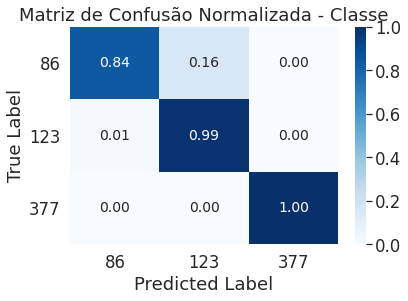

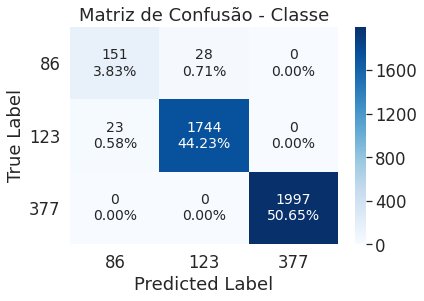

In [49]:
#transform = lambda id: id
y_true = df_test_labels_classe.to_numpy()
#y_pred = y_pred_comp.astype(int)
#y_pred = transform(y_pred_classe)
y_pred = y_pred_classe.astype(int)

plot_confusion_matrix(y_true, y_pred, entity="Classe", figsize=(6,4))
plot_confusion_matrix(y_true, y_pred, entity="Classe", figsize=(6,4), normalize=False)

In [50]:
#Descrição: https://www.scikit-yb.org/en/latest/api/classifier/classification_report.html e https://thecleverprogrammer.com/2021/07/07/classification-report-in-machine-learning/

print( skm.classification_report(y_true, y_pred, zero_division=0) )

              precision    recall  f1-score   support

          86       0.87      0.84      0.86       179
         123       0.98      0.99      0.99      1767
         377       1.00      1.00      1.00      1997

    accuracy                           0.99      3943
   macro avg       0.95      0.94      0.95      3943
weighted avg       0.99      0.99      0.99      3943



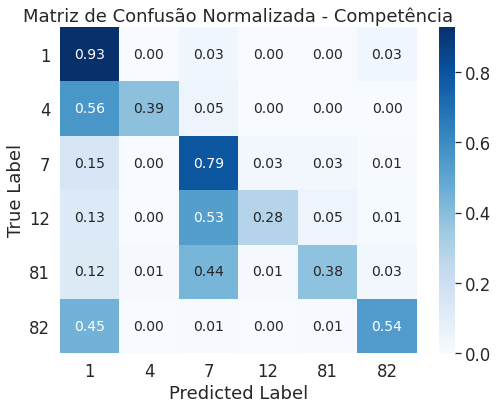

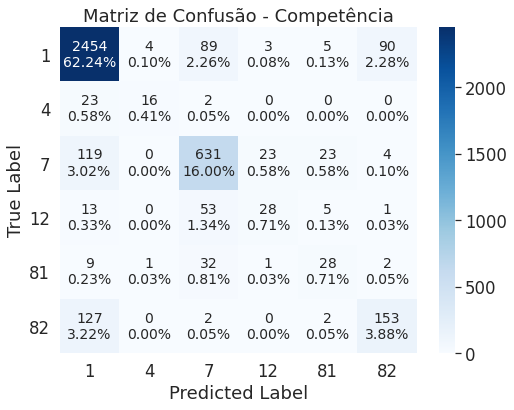

In [51]:
y_true = df_test_labels_comp.to_numpy()
y_pred = y_pred_comp.astype(int)

plot_confusion_matrix(y_true, y_pred, entity="Competência")
plot_confusion_matrix(y_true, y_pred, entity="Competência", normalize=False)

In [52]:
print( skm.classification_report(y_true, y_pred, zero_division=0) )

              precision    recall  f1-score   support

           1       0.89      0.93      0.91      2645
           4       0.76      0.39      0.52        41
           7       0.78      0.79      0.78       800
          12       0.51      0.28      0.36       100
          81       0.44      0.38      0.41        73
          82       0.61      0.54      0.57       284

    accuracy                           0.84      3943
   macro avg       0.67      0.55      0.59      3943
weighted avg       0.83      0.84      0.83      3943



In [53]:
y_true = df_test_labels_assuntos.to_numpy()
#y_pred = y_pred_comp.astype(int)
y_pred = y_pred_assuntos

confusion = multilabel_confusion_matrix(y_true, y_pred)

In [84]:
print(type(confusion[31]))
cm = [np.array(confusion[31][0] / np.sum(confusion[31][0])), np.array(confusion[31][1] / np.sum(confusion[31][1]))]
#cm = np.array(confusion[31][0] / np.sum(confusion[31][0]))

print(confusion[31])
print(cm)
type(np.asarray(cm))

<class 'numpy.ndarray'>
[[3649   11]
 [  51  232]]
[array([0.99699454, 0.00300546]), array([0.18021201, 0.81978799])]


numpy.ndarray

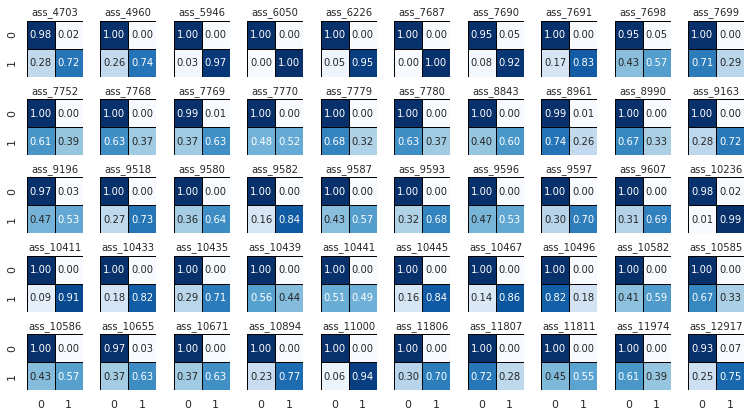

In [85]:
import math
plt.rcParams['figure.figsize'] = [11, 6]
plt.rc('ytick', labelsize=11)
plt.rc('xtick', labelsize=11)
fig, axes = plt.subplots(5, 10)
fig.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.4)

for i, matrix in enumerate(confusion):
    #mtx = matrix / np.sum(matrix) # Normaliza valores olhando a soma da matriz inteira
    mtx = [np.array(matrix[0] / np.sum(matrix[0])), np.array(matrix[1] / np.sum(matrix[1]))] # Normaliza valores olhando a soma de cada classe (linha)
    row = math.floor(i/10)
    col = i%10
    axes[row,col].set_title(df_assuntos.columns.tolist()[i], fontsize = 10)
    if col > 0:
        axes[row,col].yaxis.set_visible(False)
    if row < 4:
        axes[row,col].xaxis.set_visible(False)
    sns.heatmap(mtx, annot = True, square = True, fmt = '.2f', cbar = False, cmap = 'Blues', linecolor = 'black', linewidth = 1, ax=axes[row,col]
                    , annot_kws={"fontsize":10})

plt.show()

In [56]:
print( skm.classification_report(y_true, y_pred, zero_division=0) )

              precision    recall  f1-score   support

           0       0.45      0.72      0.56        69
           1       1.00      0.74      0.85        72
           2       1.00      0.97      0.98       126
           3       0.82      1.00      0.90        41
           4       0.99      0.95      0.97       168
           5       1.00      1.00      1.00        44
           6       0.22      0.92      0.35        64
           7       1.00      0.83      0.91       193
           8       0.11      0.57      0.19        46
           9       1.00      0.29      0.45        38
          10       1.00      0.39      0.57       198
          11       1.00      0.37      0.54        60
          12       0.45      0.63      0.52        27
          13       1.00      0.52      0.68       191
          14       1.00      0.32      0.48       195
          15       0.98      0.37      0.53       158
          16       0.91      0.60      0.73       134
          17       0.32    

In [57]:
keras_model = model.export_model()
keras_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
expand_last_dim (ExpandLastDim) (None, 1)            0           input_1[0][0]                    
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 64)           0           expand_last_dim[0][0]            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 64, 128)      640128      text_vectorization[0][0]         
______________________________________________________________________________________________

In [58]:
#import keras
#import pydotplus
#from keras.utils.vis_utils import model_to_dot
#keras.utils.vis_utils.pydot = pydot

#plot_model(model.tuner.get_best_models()[0], to_file='model.png')

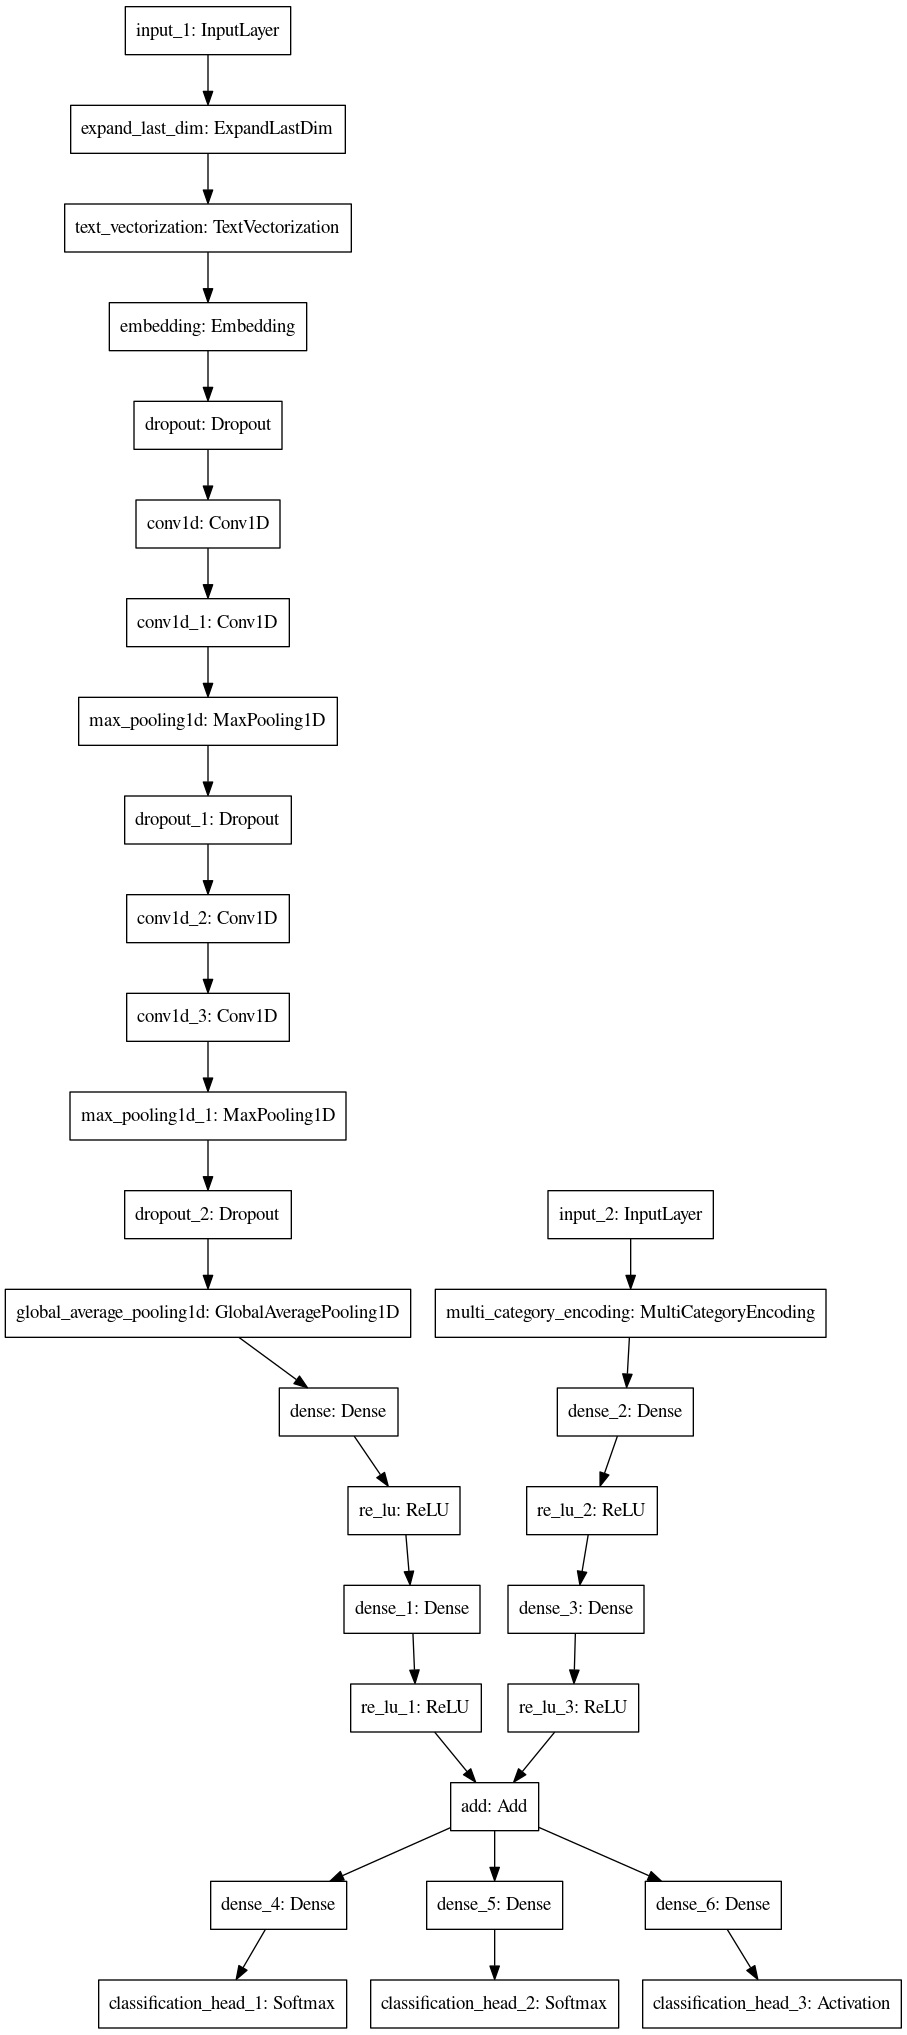

In [59]:
import keras
import pydotplus
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot
plot_model(keras_model, to_file='model.png')

In [60]:
try:
  keras_model.save("model_autokeras-tf", save_format="tf")
except:
  keras_model.save("model_autokeras-h5.h5")

/home/t0085217/.local/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_autokeras-tf/assets
